<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/tfidf/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Init { form-width: "25%" }

import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

!pip3 install wikipedia-api > null
import wikipediaapi
!pip install tokenizers > null
from tokenizers import BertWordPieceTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-03-13 16:05:13--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  72.1MB/s    in 0.4s    

2021-03-13 16:05:14 (72.1 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [3]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming
from tqdm.notebook import tqdm

def preprocess_text(text):
    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]
    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them
    return text

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])

# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for the letter was addressed to Angela Merkel and Nkosazana DlaminiZuma urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new

In [4]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()  # remove samples that contain errors from the dataset

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [5]:
#@title train-test split { form-width: "25%" }

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

split_value = 0.1 #@param {type:"number"} 
test_dim = int(len(df_clean['title'].unique()) * split_value)
test_titles = np.random.choice(df_clean['title'].unique(), size=test_dim, replace=False)

# creating train and test sets
df_test = df_clean[df_clean['title'].isin(test_titles)]
df_train = df_clean[~(df_clean['title'].isin(test_titles))]

df_original_test = df_original_clean[df_original_clean['title'].isin(test_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(test_titles))]

In [6]:
#@title tf-idf { form-width: "25%" }

vectorizer =  TfidfVectorizer()

# get unique preprocessed passages from the training set
passage_prep_train = df_train['passage'].unique().tolist()
# use the tf-idf vectorizer to learn the vocabulary and the inverse document frequency, computing the document-term matrix on the training set
passage_tf_idf = vectorizer.fit_transform(passage_prep_train)

# obtain unique passages from the test set
passage_prep_test = df_test['passage'].unique().tolist() # preprocessed
passage_test = df_original_test['passage'].unique()      # original

# transform test passages and questions
passage_test_tf_idf = vectorizer.transform(passage_prep_test)
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

# compute similarity
results = cosine_similarity(passage_test_tf_idf, question_tf_idf)


[0.5450475657526581, 0.6624230554001119, 0.7250979294907667, 0.7620313374370453, 0.7890318970341355, 0.8115556799104645, 0.8282036933407946, 0.8412143256855065, 0.8538052602126469, 0.8649972020145495]


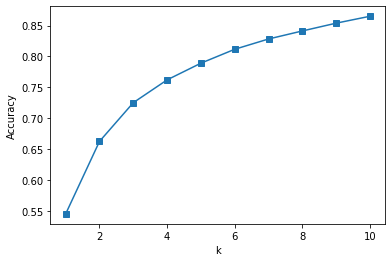

In [ ]:
#@title single passage score { form-width: "25%" }

# In this cell we evaluate how effective is tf-idf in finding the right passage for a question

# we compute the result accuracy for each k between 1 and k_results:
# in particular, for each question we take the k most probable passages and check
# if the right passage is among them 
k_results = 10  

tp = 0 #true positives
accuracy = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            tp+=1
    accuracy.append(tp/len(df_original_test))
    tp = 0

print(accuracy,sep='\n')
plt.plot(list(range(1, k_results+1)),accuracy,"-s");
plt.xlabel("k");
plt.ylabel("Accuracy");


[0.8547845551203134, 0.9162003357582541, 0.9360660324566312, 0.9457190822607723, 0.9534135422495803, 0.9597090095131505, 0.9629266927811976, 0.9657246782316732, 0.9682428651371013, 0.9710408505875769]


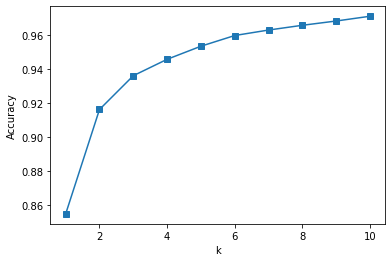

In [ ]:
#@title full document score { form-width: "25%" }

# In this cell we evaluate how effective is tf-idf in finding the right document (passage title) for a question

passage_group = df_original_test.groupby('passage').groups

k_results = 10
tp = 0
document_accuracy = []
for k in tqdm(range(1,k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        for h in range(1,k+1):
            if df_original_test["title"].tolist()[j] == df_original_test.loc[passage_group[passage_test[result[-h]]][0]]['title']:
                tp+=1
                break
    document_accuracy.append(tp/len(df_original_test))
    tp = 0

print(document_accuracy,sep='\n')
plt.plot(list(range(1, k_results+1)),document_accuracy,"-s");
plt.xlabel("k");
plt.ylabel("Accuracy");

In [18]:
#@title precision - recall - mrr { form-width: "25%" }

max_documents = 50 
relevant_documents = 0

micro_precision = []
micro_recall = []
mrr = []

for retrieved_documents in tqdm(range(1, max_documents+1)):
    precision = []
    recall = []
    reciprocal_ranks = []
    for j,result in enumerate(results.T):
        relevant_documents = 0
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-retrieved_documents:].tolist()]]:
            relevant_documents = 1
            rank = 1+[txt for txt in passage_test[result[-retrieved_documents:].tolist()]].index(df_original_test['passage'].tolist()[j])
            reciprocal_ranks.append(1/rank) 
        else:
            reciprocal_ranks.append(0) 
        
        precision.append(relevant_documents/retrieved_documents)
        recall.append(relevant_documents)

    micro_precision.append(np.mean(precision))
    micro_recall.append(np.mean(recall))
    mrr.append(np.mean(reciprocal_ranks))


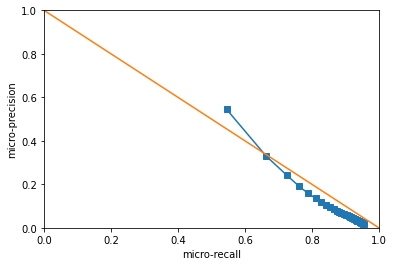

In [22]:
#@title precision - recall { form-width: "25%" }

plt.plot(micro_recall, micro_precision, "-s");
plt.plot([0,1], [1,0]);
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("micro-recall");
plt.ylabel("micro-precision");

(0.0, 1.0)

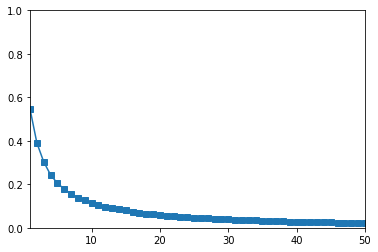

In [21]:
#@title mean reciprocal rank { form-width: "25%" }

plt.plot(list(range(1,51)), mrr, "-s");
plt.xlim((1,50))
plt.ylim((0,1))